# 0- Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import locale

import warnings
warnings.filterwarnings("ignore")

try:
    from amplpy import AMPL, tools
except ImportError:
    # Caso ocorra um erro ao importar, instala amplpy e tenta importar novamente
    %pip install amplpy
    from amplpy import AMPL, tools

In [2]:
licenca ="default"


ampl = tools.ampl_notebook(
    modules=["highs", "gcg", "gurobi", "cplex"],  # Módulos a serem instalados
    license_uuid=licenca,  # Licença a ser utilizada
    g=globals()  # Instancia o objeto AMPL e registra os comandos mágicos
)

# 1- Funções

In [3]:
def transforma_obj_to_str(df):
    var_obj = list(df.select_dtypes('object').columns)

    df[var_obj] = df[var_obj].astype('string')

    return df

# 2- Base

## 2.1 - Produtos

In [4]:
df_produtos = pd.read_excel('../../01-Data/extra/dados.xlsx', sheet_name='produtos')
df_produtos

,instancia,classe_onda,tipo_buffer,sku,tipo_caixa_padrao,item_pai,codigo_cor,sku_unit_kg,sku_unit_m3,inner
0,instancia-1,classe_onda-1,tipo_buffer-1,sku-12155,CARTON_M,itempai-3488,cor-36,0.100,0.001289,1
1,instancia-1,classe_onda-1,tipo_buffer-1,sku-12156,CARTON_M,itempai-3488,cor-36,0.100,0.002537,1
2,instancia-1,classe_onda-1,tipo_buffer-1,sku-12157,CARTON_M,itempai-3488,cor-36,0.140,0.001098,1
3,instancia-1,classe_onda-1,tipo_buffer-1,sku-12158,CARTON_M,itempai-3488,cor-36,0.127,0.002070,1
4,instancia-1,classe_onda-1,tipo_buffer-1,sku-12159,CARTON_M,itempai-3488,cor-36,0.120,0.001840,1
...,...,...,...,...,...,...,...,...,...,...
43866,instancia-5,classe_onda-9,tipo_buffer-1,sku-9749,CARTON_S,itempai-2852,cor-989,0.260,0.000584,1
43867,instancia-5,classe_onda-9,tipo_buffer-1,sku-977,CARTON_S,itempai-248,cor-989,0.240,0.000374,1
43868,instancia-5,classe_onda-9,tipo_buffer-1,sku-980,CARTON_S,itempai-250,cor-23,0.260,0.001000,1
43869,instancia-5,classe_onda-9,tipo_buffer-1,sku-981,CARTON_S,itempai-251,cor-989,0.285,0.000812,1


In [5]:
df_produtos = transforma_obj_to_str(df_produtos)

In [6]:
df_produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43871 entries, 0 to 43870
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   instancia          43871 non-null  string 
 1   classe_onda        43871 non-null  string 
 2   tipo_buffer        43871 non-null  string 
 3   sku                43871 non-null  string 
 4   tipo_caixa_padrao  43871 non-null  string 
 5   item_pai           43871 non-null  string 
 6   codigo_cor         43871 non-null  string 
 7   sku_unit_kg        43871 non-null  float64
 8   sku_unit_m3        43871 non-null  float64
 9   inner              43871 non-null  int64  
dtypes: float64(2), int64(1), string(7)
memory usage: 3.3 MB


In [7]:
df_produtos['chave_produtos'] = df_produtos['instancia'] + '_' + df_produtos['classe_onda'] + '_' + df_produtos['tipo_buffer'] \
                            + '_' +df_produtos['sku']

In [8]:
df_produtos['chave_caixas'] = df_produtos['instancia'] + '_' + df_produtos['classe_onda'] + '_' + df_produtos['tipo_buffer'] \
                            + '_' + df_produtos['tipo_caixa_padrao']

In [9]:
df_produtos[['instancia', 'classe_onda', 'tipo_buffer', 'sku']].value_counts()

instancia    classe_onda    tipo_buffer    sku      
instancia-1  classe_onda-1  tipo_buffer-1  sku-12155    1
instancia-4  classe_onda-2  tipo_buffer-2  sku-4164     1
                                           sku-4150     1
                                           sku-4151     1
                                           sku-4152     1
                                                       ..
instancia-2  classe_onda-2  tipo_buffer-2  sku-7485     1
                                           sku-7488     1
                                           sku-7489     1
                                           sku-7490     1
instancia-5  classe_onda-9  tipo_buffer-1  sku-982      1
Name: count, Length: 43871, dtype: int64

In [10]:
df_produtos[['instancia', 'tipo_buffer', 'sku']].value_counts()

instancia    tipo_buffer    sku     
instancia-1  tipo_buffer-1  sku-10      1
instancia-4  tipo_buffer-1  sku-4897    1
                            sku-4888    1
                            sku-4889    1
                            sku-4890    1
                                       ..
instancia-2  tipo_buffer-1  sku-5183    1
                            sku-5184    1
                            sku-5185    1
                            sku-5187    1
instancia-5  tipo_buffer-2  sku-9994    1
Name: count, Length: 43871, dtype: int64

## 2.2- Caixas

In [11]:
df_caixas = pd.read_excel('../../01-Data/extra/dados.xlsx', sheet_name='tipos caixas')
df_caixas

,instancia,tipo_buffer,classe_onda,tipo_caixa,caixa_cap_pecas,caixa_cap_kg,caixa_cap_m3,caixa_m3_externo
0,instancia-1,tipo_buffer-1,classe_onda-1,CARTON_M,170,23,0.125392,0.075995
1,instancia-1,tipo_buffer-1,classe_onda-10,CARTON_M,170,23,0.125392,0.075995
2,instancia-1,tipo_buffer-1,classe_onda-11,CARTON_M,170,23,0.125392,0.075995
3,instancia-1,tipo_buffer-1,classe_onda-2,CARTON_M,170,23,0.125392,0.075995
4,instancia-1,tipo_buffer-1,classe_onda-3,CARTON_L,170,23,0.074563,0.093204
...,...,...,...,...,...,...,...,...
136,instancia-5,tipo_buffer-2,classe_onda-3,CARTON_M,512,23,0.125392,0.075995
137,instancia-5,tipo_buffer-2,classe_onda-4,CARTON_M,512,23,0.113993,0.075995
138,instancia-5,tipo_buffer-2,classe_onda-5,CARTON_L,512,23,0.074563,0.093204
139,instancia-5,tipo_buffer-2,classe_onda-5,CARTON_M,512,23,0.125392,0.075995


In [12]:
df_caixas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instancia         141 non-null    object 
 1   tipo_buffer       141 non-null    object 
 2   classe_onda       141 non-null    object 
 3   tipo_caixa        141 non-null    object 
 4   caixa_cap_pecas   141 non-null    int64  
 5   caixa_cap_kg      141 non-null    int64  
 6   caixa_cap_m3      141 non-null    float64
 7   caixa_m3_externo  141 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 8.9+ KB


In [13]:
df_caixas = transforma_obj_to_str(df_caixas)

In [14]:
df_caixas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instancia         141 non-null    string 
 1   tipo_buffer       141 non-null    string 
 2   classe_onda       141 non-null    string 
 3   tipo_caixa        141 non-null    string 
 4   caixa_cap_pecas   141 non-null    int64  
 5   caixa_cap_kg      141 non-null    int64  
 6   caixa_cap_m3      141 non-null    float64
 7   caixa_m3_externo  141 non-null    float64
dtypes: float64(2), int64(2), string(4)
memory usage: 8.9 KB


In [15]:
df_caixas.columns

Index(['instancia', 'tipo_buffer', 'classe_onda', 'tipo_caixa',
       'caixa_cap_pecas', 'caixa_cap_kg', 'caixa_cap_m3', 'caixa_m3_externo'],
      dtype='object')

In [16]:
df_caixas['chave_caixas'] = df_caixas['instancia'] + '_' + df_caixas['classe_onda'] + '_' + df_caixas['tipo_buffer'] \
                            + '_' + df_caixas['tipo_caixa']

In [17]:
df_caixas['chave_caixas'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 141 entries, 0 to 140
Series name: chave_caixas
Non-Null Count  Dtype 
--------------  ----- 
141 non-null    string
dtypes: string(1)
memory usage: 1.2 KB


## 2.3- Lojas

In [18]:
df_loja = pd.read_excel('../../01-Data/extra/dados.xlsx', sheet_name='lojas')
df_loja

,instancia,rota,loja,cap_loja_m3
0,instancia-1,rota-1,loja-209,NaN
1,instancia-1,rota-17,loja-259,NaN
2,instancia-1,rota-17,loja-83,15.0
3,instancia-1,rota-24,loja-112,10.0
4,instancia-1,rota-25,loja-35,22.0
...,...,...,...,...
355,instancia-5,rota-69,loja-89,NaN
356,instancia-5,rota-7,loja-118,16.5
357,instancia-5,rota-7,loja-226,13.8
358,instancia-5,rota-7,loja-273,NaN


In [19]:
df_loja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   instancia    360 non-null    object 
 1   rota         360 non-null    object 
 2   loja         360 non-null    object 
 3   cap_loja_m3  148 non-null    float64
dtypes: float64(1), object(3)
memory usage: 11.4+ KB


In [20]:
df_loja = transforma_obj_to_str(df_loja)

In [21]:
df_loja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   instancia    360 non-null    string 
 1   rota         360 non-null    string 
 2   loja         360 non-null    string 
 3   cap_loja_m3  148 non-null    float64
dtypes: float64(1), string(3)
memory usage: 11.4 KB


## 2.4- Rotas

In [22]:
df_rotas = pd.read_excel('../../01-Data/extra/dados.xlsx', sheet_name='rotas')
df_rotas

,instancia,rota,cap_rota_m3
0,instancia-1,rota-1,46
1,instancia-1,rota-17,15
2,instancia-1,rota-24,31
3,instancia-1,rota-25,46
4,instancia-1,rota-30,46
...,...,...,...
80,instancia-5,rota-5,15
81,instancia-5,rota-6,31
82,instancia-5,rota-68,31
83,instancia-5,rota-69,92


In [23]:
df_rotas = transforma_obj_to_str(df_rotas)

In [24]:
df_rotas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instancia    85 non-null     string
 1   rota         85 non-null     string
 2   cap_rota_m3  85 non-null     int64 
dtypes: int64(1), string(2)
memory usage: 2.1 KB


## 2.5- Ordens de produção

In [25]:
df_ord_producao = pd.read_csv('../../01-Data/extra/ordens producao.csv')
df_ord_producao

,instancia,alocacao_id,alocacao_datahora,tipo_buffer,loja,sku,pecas
0,instancia-1,alocacao-1,2024-05-29 19:07:06.923,tipo_buffer-1,loja-296,sku-77,7
1,instancia-1,alocacao-1000,2024-05-23 11:12:43.127,tipo_buffer-1,loja-58,sku-10540,14
2,instancia-1,alocacao-10000,2024-06-14 18:05:48.893,tipo_buffer-2,loja-209,sku-11595,1
3,instancia-1,alocacao-10001,2024-06-14 18:05:42.413,tipo_buffer-2,loja-209,sku-11040,1
4,instancia-1,alocacao-10002,2024-06-14 18:05:46.887,tipo_buffer-2,loja-209,sku-6714,1
...,...,...,...,...,...,...,...
228578,instancia-5,alocacao-9633,2024-06-14 17:01:17.647,tipo_buffer-1,loja-15,sku-3806,2
228579,instancia-5,alocacao-9633,2024-06-14 17:01:17.647,tipo_buffer-1,loja-188,sku-3806,4
228580,instancia-5,alocacao-9633,2024-06-14 17:01:17.647,tipo_buffer-1,loja-94,sku-3806,2
228581,instancia-5,alocacao-964,2024-05-22 13:25:20.723,tipo_buffer-2,loja-15,sku-2720,2


In [26]:
df_ord_producao = transforma_obj_to_str(df_ord_producao)

In [27]:
df_ord_producao['alocacao_datahora'] = pd.to_datetime(df_ord_producao['alocacao_datahora'])

In [28]:
df_ord_producao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228583 entries, 0 to 228582
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   instancia          228583 non-null  string        
 1   alocacao_id        228583 non-null  string        
 2   alocacao_datahora  228583 non-null  datetime64[ns]
 3   tipo_buffer        228583 non-null  string        
 4   loja               228583 non-null  string        
 5   sku                228583 non-null  string        
 6   pecas              228583 non-null  int64         
dtypes: datetime64[ns](1), int64(1), string(5)
memory usage: 12.2 MB


In [29]:
df_ord_producao['chave_produtos_aloc'] = df_ord_producao['instancia'] + '_' + df_ord_producao['alocacao_id'] + '_' + df_ord_producao['loja'] \
                            + df_ord_producao['sku']

In [30]:
df_ord_producao['chave_produtos_aloc'].value_counts()

chave_produtos_aloc
instancia-1_alocacao-1_loja-296sku-77           1
instancia-1_alocacao-10009_loja-209sku-12199    1
instancia-1_alocacao-10098_loja-209sku-5056     1
instancia-1_alocacao-10010_loja-209sku-3501     1
instancia-1_alocacao-10000_loja-209sku-11595    1
                                               ..
instancia-5_alocacao-9633_loja-138sku-3806      1
instancia-5_alocacao-9633_loja-146sku-3806      1
instancia-5_alocacao-9633_loja-15sku-3806       1
instancia-5_alocacao-9633_loja-188sku-3806      1
instancia-5_alocacao-964_loja-37sku-2720        1
Name: count, Length: 228583, dtype: Int64

In [31]:
pd.DataFrame(df_ord_producao[['instancia', 'alocacao_id', 'loja','sku']].value_counts()).head(20)

count
instancia   alocacao_id    loja     sku            
instancia-1 alocacao-1     loja-296 sku-77        1
instancia-4 alocacao-18285 loja-87  sku-1084      1
            alocacao-18283 loja-87  sku-919       1
                                    sku-920       1
            alocacao-18284 loja-87  sku-1903      1
                                    sku-1936      1
                                    sku-1968      1
                                    sku-2483      1
                                    sku-3568      1
                                    sku-3569      1
                                    sku-3570      1
                                    sku-3571      1
            alocacao-18285 loja-87  sku-1083      1
                                    sku-1085      1
            alocacao-18282 loja-87  sku-2116      1
            alocacao-18285 loja-87  sku-1086      1
                                    sku-1087      1
                                    sku-1088      1
                                    sku-1089      1
                                    sku-1220      1

### 2.5.1- Completar o dataset de ordem de produção

In [32]:
df_produtos.columns

Index(['instancia', 'classe_onda', 'tipo_buffer', 'sku', 'tipo_caixa_padrao',
       'item_pai', 'codigo_cor', 'sku_unit_kg', 'sku_unit_m3', 'inner',
       'chave_produtos', 'chave_caixas'],
      dtype='object')

In [33]:
df_ord_producao.columns

Index(['instancia', 'alocacao_id', 'alocacao_datahora', 'tipo_buffer', 'loja',
       'sku', 'pecas', 'chave_produtos_aloc'],
      dtype='object')

In [34]:
df_ord_producao_completo = df_ord_producao.merge(df_produtos, on=['instancia', 'tipo_buffer', 'sku'], how= 'inner')
df_ord_producao_completo.head()

,instancia,alocacao_id,alocacao_datahora,tipo_buffer,loja,sku,pecas,chave_produtos_aloc,classe_onda,tipo_caixa_padrao,item_pai,codigo_cor,sku_unit_kg,sku_unit_m3,inner,chave_produtos,chave_caixas
0,instancia-1,alocacao-1,2024-05-29 19:07:06.923,tipo_buffer-1,loja-296,sku-77,7,instancia-1_alocacao-1_loja-296sku-77,classe_onda-11,CARTON_M,itempai-16,cor-786,0.78,0.004776,1,instancia-1_classe_onda-11_tipo_buffer-1_sku-77,instancia-1_classe_onda-11_tipo_buffer-1_CARTON_M
1,instancia-1,alocacao-1000,2024-05-23 11:12:43.127,tipo_buffer-1,loja-58,sku-10540,14,instancia-1_alocacao-1000_loja-58sku-10540,classe_onda-6,CARTON_M,itempai-2971,cor-718,0.41,0.006154,2,instancia-1_classe_onda-6_tipo_buffer-1_sku-10540,instancia-1_classe_onda-6_tipo_buffer-1_CARTON_M
2,instancia-1,alocacao-10000,2024-06-14 18:05:48.893,tipo_buffer-2,loja-209,sku-11595,1,instancia-1_alocacao-10000_loja-209sku-11595,classe_onda-3,CARTON_M,itempai-3337,cor-26,0.29,0.005676,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11595,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M
3,instancia-1,alocacao-10001,2024-06-14 18:05:42.413,tipo_buffer-2,loja-209,sku-11040,1,instancia-1_alocacao-10001_loja-209sku-11040,classe_onda-3,CARTON_M,itempai-3199,cor-26,0.21,0.001313,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11040,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M
4,instancia-1,alocacao-10002,2024-06-14 18:05:46.887,tipo_buffer-2,loja-209,sku-6714,1,instancia-1_alocacao-10002_loja-209sku-6714,classe_onda-3,CARTON_M,itempai-2005,cor-26,0.50,0.011151,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-6714,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M


In [35]:
df_ord_producao_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228583 entries, 0 to 228582
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   instancia            228583 non-null  string        
 1   alocacao_id          228583 non-null  string        
 2   alocacao_datahora    228583 non-null  datetime64[ns]
 3   tipo_buffer          228583 non-null  string        
 4   loja                 228583 non-null  string        
 5   sku                  228583 non-null  string        
 6   pecas                228583 non-null  int64         
 7   chave_produtos_aloc  228583 non-null  string        
 8   classe_onda          228583 non-null  string        
 9   tipo_caixa_padrao    228583 non-null  string        
 10  item_pai             228583 non-null  string        
 11  codigo_cor           228583 non-null  string        
 12  sku_unit_kg          228583 non-null  float64       
 13  sku_unit_m3   

Juntar com dados das caixas

In [36]:
df_caixas.columns

Index(['instancia', 'tipo_buffer', 'classe_onda', 'tipo_caixa',
       'caixa_cap_pecas', 'caixa_cap_kg', 'caixa_cap_m3', 'caixa_m3_externo',
       'chave_caixas'],
      dtype='object')

In [37]:
df_caixas = df_caixas.rename(columns={'tipo_caixa':'tipo_caixa_padrao'})
df_caixas.head()

,instancia,tipo_buffer,classe_onda,tipo_caixa_padrao,caixa_cap_pecas,caixa_cap_kg,caixa_cap_m3,caixa_m3_externo,chave_caixas
0,instancia-1,tipo_buffer-1,classe_onda-1,CARTON_M,170,23,0.125392,0.075995,instancia-1_classe_onda-1_tipo_buffer-1_CARTON_M
1,instancia-1,tipo_buffer-1,classe_onda-10,CARTON_M,170,23,0.125392,0.075995,instancia-1_classe_onda-10_tipo_buffer-1_CARTON_M
2,instancia-1,tipo_buffer-1,classe_onda-11,CARTON_M,170,23,0.125392,0.075995,instancia-1_classe_onda-11_tipo_buffer-1_CARTON_M
3,instancia-1,tipo_buffer-1,classe_onda-2,CARTON_M,170,23,0.125392,0.075995,instancia-1_classe_onda-2_tipo_buffer-1_CARTON_M
4,instancia-1,tipo_buffer-1,classe_onda-3,CARTON_L,170,23,0.074563,0.093204,instancia-1_classe_onda-3_tipo_buffer-1_CARTON_L


In [38]:
df_ord_producao_completo_cx = df_ord_producao_completo.merge(df_caixas.drop(columns='chave_caixas'), on=['instancia','tipo_buffer','classe_onda','tipo_caixa_padrao'], how='inner')
df_ord_producao_completo_cx.head()

,instancia,alocacao_id,alocacao_datahora,tipo_buffer,loja,sku,pecas,chave_produtos_aloc,classe_onda,tipo_caixa_padrao,...,codigo_cor,sku_unit_kg,sku_unit_m3,inner,chave_produtos,chave_caixas,caixa_cap_pecas,caixa_cap_kg,caixa_cap_m3,caixa_m3_externo
0,instancia-1,alocacao-1,2024-05-29 19:07:06.923,tipo_buffer-1,loja-296,sku-77,7,instancia-1_alocacao-1_loja-296sku-77,classe_onda-11,CARTON_M,...,cor-786,0.78,0.004776,1,instancia-1_classe_onda-11_tipo_buffer-1_sku-77,instancia-1_classe_onda-11_tipo_buffer-1_CARTON_M,170,23,0.125392,0.075995
1,instancia-1,alocacao-1000,2024-05-23 11:12:43.127,tipo_buffer-1,loja-58,sku-10540,14,instancia-1_alocacao-1000_loja-58sku-10540,classe_onda-6,CARTON_M,...,cor-718,0.41,0.006154,2,instancia-1_classe_onda-6_tipo_buffer-1_sku-10540,instancia-1_classe_onda-6_tipo_buffer-1_CARTON_M,170,23,0.091194,0.075995
2,instancia-1,alocacao-10000,2024-06-14 18:05:48.893,tipo_buffer-2,loja-209,sku-11595,1,instancia-1_alocacao-10000_loja-209sku-11595,classe_onda-3,CARTON_M,...,cor-26,0.29,0.005676,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11595,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995
3,instancia-1,alocacao-10001,2024-06-14 18:05:42.413,tipo_buffer-2,loja-209,sku-11040,1,instancia-1_alocacao-10001_loja-209sku-11040,classe_onda-3,CARTON_M,...,cor-26,0.21,0.001313,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11040,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995
4,instancia-1,alocacao-10002,2024-06-14 18:05:46.887,tipo_buffer-2,loja-209,sku-6714,1,instancia-1_alocacao-10002_loja-209sku-6714,classe_onda-3,CARTON_M,...,cor-26,0.50,0.011151,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-6714,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995


Juntar com dados da rota

In [39]:
df_ord_producao_completo_loja = df_ord_producao_completo_cx.merge(df_loja, on=['instancia','loja'], how='inner')
df_ord_producao_completo_loja.head()

,instancia,alocacao_id,alocacao_datahora,tipo_buffer,loja,sku,pecas,chave_produtos_aloc,classe_onda,tipo_caixa_padrao,...,sku_unit_m3,inner,chave_produtos,chave_caixas,caixa_cap_pecas,caixa_cap_kg,caixa_cap_m3,caixa_m3_externo,rota,cap_loja_m3
0,instancia-1,alocacao-1,2024-05-29 19:07:06.923,tipo_buffer-1,loja-296,sku-77,7,instancia-1_alocacao-1_loja-296sku-77,classe_onda-11,CARTON_M,...,0.004776,1,instancia-1_classe_onda-11_tipo_buffer-1_sku-77,instancia-1_classe_onda-11_tipo_buffer-1_CARTON_M,170,23,0.125392,0.075995,rota-43,NaN
1,instancia-1,alocacao-1000,2024-05-23 11:12:43.127,tipo_buffer-1,loja-58,sku-10540,14,instancia-1_alocacao-1000_loja-58sku-10540,classe_onda-6,CARTON_M,...,0.006154,2,instancia-1_classe_onda-6_tipo_buffer-1_sku-10540,instancia-1_classe_onda-6_tipo_buffer-1_CARTON_M,170,23,0.091194,0.075995,rota-40,19.25
2,instancia-1,alocacao-10000,2024-06-14 18:05:48.893,tipo_buffer-2,loja-209,sku-11595,1,instancia-1_alocacao-10000_loja-209sku-11595,classe_onda-3,CARTON_M,...,0.005676,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11595,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995,rota-1,NaN
3,instancia-1,alocacao-10001,2024-06-14 18:05:42.413,tipo_buffer-2,loja-209,sku-11040,1,instancia-1_alocacao-10001_loja-209sku-11040,classe_onda-3,CARTON_M,...,0.001313,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11040,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995,rota-1,NaN
4,instancia-1,alocacao-10002,2024-06-14 18:05:46.887,tipo_buffer-2,loja-209,sku-6714,1,instancia-1_alocacao-10002_loja-209sku-6714,classe_onda-3,CARTON_M,...,0.011151,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-6714,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995,rota-1,NaN


In [40]:
# loja com valor nulo de capacidade têm capacidade 'infinita' (sem restrição)
df_ord_producao_completo_loja['cap_loja_m3'] = df_ord_producao_completo_loja['cap_loja_m3'].fillna(np.inf)

In [41]:
df_ord_producao_completo_loja.head()

,instancia,alocacao_id,alocacao_datahora,tipo_buffer,loja,sku,pecas,chave_produtos_aloc,classe_onda,tipo_caixa_padrao,...,sku_unit_m3,inner,chave_produtos,chave_caixas,caixa_cap_pecas,caixa_cap_kg,caixa_cap_m3,caixa_m3_externo,rota,cap_loja_m3
0,instancia-1,alocacao-1,2024-05-29 19:07:06.923,tipo_buffer-1,loja-296,sku-77,7,instancia-1_alocacao-1_loja-296sku-77,classe_onda-11,CARTON_M,...,0.004776,1,instancia-1_classe_onda-11_tipo_buffer-1_sku-77,instancia-1_classe_onda-11_tipo_buffer-1_CARTON_M,170,23,0.125392,0.075995,rota-43,inf
1,instancia-1,alocacao-1000,2024-05-23 11:12:43.127,tipo_buffer-1,loja-58,sku-10540,14,instancia-1_alocacao-1000_loja-58sku-10540,classe_onda-6,CARTON_M,...,0.006154,2,instancia-1_classe_onda-6_tipo_buffer-1_sku-10540,instancia-1_classe_onda-6_tipo_buffer-1_CARTON_M,170,23,0.091194,0.075995,rota-40,19.25
2,instancia-1,alocacao-10000,2024-06-14 18:05:48.893,tipo_buffer-2,loja-209,sku-11595,1,instancia-1_alocacao-10000_loja-209sku-11595,classe_onda-3,CARTON_M,...,0.005676,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11595,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995,rota-1,inf
3,instancia-1,alocacao-10001,2024-06-14 18:05:42.413,tipo_buffer-2,loja-209,sku-11040,1,instancia-1_alocacao-10001_loja-209sku-11040,classe_onda-3,CARTON_M,...,0.001313,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11040,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995,rota-1,inf
4,instancia-1,alocacao-10002,2024-06-14 18:05:46.887,tipo_buffer-2,loja-209,sku-6714,1,instancia-1_alocacao-10002_loja-209sku-6714,classe_onda-3,CARTON_M,...,0.011151,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-6714,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995,rota-1,inf


Adicionar a capacidade da rota

In [42]:
df_ord_producao_completo_loja_rota = df_ord_producao_completo_loja.merge(df_rotas, on=['instancia','rota'], how='inner')
df_ord_producao_completo_loja_rota.head()

,instancia,alocacao_id,alocacao_datahora,tipo_buffer,loja,sku,pecas,chave_produtos_aloc,classe_onda,tipo_caixa_padrao,...,inner,chave_produtos,chave_caixas,caixa_cap_pecas,caixa_cap_kg,caixa_cap_m3,caixa_m3_externo,rota,cap_loja_m3,cap_rota_m3
0,instancia-1,alocacao-1,2024-05-29 19:07:06.923,tipo_buffer-1,loja-296,sku-77,7,instancia-1_alocacao-1_loja-296sku-77,classe_onda-11,CARTON_M,...,1,instancia-1_classe_onda-11_tipo_buffer-1_sku-77,instancia-1_classe_onda-11_tipo_buffer-1_CARTON_M,170,23,0.125392,0.075995,rota-43,inf,46
1,instancia-1,alocacao-1000,2024-05-23 11:12:43.127,tipo_buffer-1,loja-58,sku-10540,14,instancia-1_alocacao-1000_loja-58sku-10540,classe_onda-6,CARTON_M,...,2,instancia-1_classe_onda-6_tipo_buffer-1_sku-10540,instancia-1_classe_onda-6_tipo_buffer-1_CARTON_M,170,23,0.091194,0.075995,rota-40,19.25,46
2,instancia-1,alocacao-10000,2024-06-14 18:05:48.893,tipo_buffer-2,loja-209,sku-11595,1,instancia-1_alocacao-10000_loja-209sku-11595,classe_onda-3,CARTON_M,...,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11595,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995,rota-1,inf,46
3,instancia-1,alocacao-10001,2024-06-14 18:05:42.413,tipo_buffer-2,loja-209,sku-11040,1,instancia-1_alocacao-10001_loja-209sku-11040,classe_onda-3,CARTON_M,...,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-11040,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995,rota-1,inf,46
4,instancia-1,alocacao-10002,2024-06-14 18:05:46.887,tipo_buffer-2,loja-209,sku-6714,1,instancia-1_alocacao-10002_loja-209sku-6714,classe_onda-3,CARTON_M,...,1,instancia-1_classe_onda-3_tipo_buffer-2_sku-6714,instancia-1_classe_onda-3_tipo_buffer-2_CARTON_M,512,23,0.125392,0.075995,rota-1,inf,46


In [43]:
df_ord_producao_completo_loja_rota.columns

Index(['instancia', 'alocacao_id', 'alocacao_datahora', 'tipo_buffer', 'loja',
       'sku', 'pecas', 'chave_produtos_aloc', 'classe_onda',
       'tipo_caixa_padrao', 'item_pai', 'codigo_cor', 'sku_unit_kg',
       'sku_unit_m3', 'inner', 'chave_produtos', 'chave_caixas',
       'caixa_cap_pecas', 'caixa_cap_kg', 'caixa_cap_m3', 'caixa_m3_externo',
       'rota', 'cap_loja_m3', 'cap_rota_m3'],
      dtype='object')

In [44]:
df_producao_final = df_ord_producao_completo_loja_rota.copy()
df_producao_final = df_producao_final.drop(columns=['chave_produtos_aloc','chave_produtos', 'chave_caixas'])
df_producao_final.head()

,instancia,alocacao_id,alocacao_datahora,tipo_buffer,loja,sku,pecas,classe_onda,tipo_caixa_padrao,item_pai,...,sku_unit_kg,sku_unit_m3,inner,caixa_cap_pecas,caixa_cap_kg,caixa_cap_m3,caixa_m3_externo,rota,cap_loja_m3,cap_rota_m3
0,instancia-1,alocacao-1,2024-05-29 19:07:06.923,tipo_buffer-1,loja-296,sku-77,7,classe_onda-11,CARTON_M,itempai-16,...,0.78,0.004776,1,170,23,0.125392,0.075995,rota-43,inf,46
1,instancia-1,alocacao-1000,2024-05-23 11:12:43.127,tipo_buffer-1,loja-58,sku-10540,14,classe_onda-6,CARTON_M,itempai-2971,...,0.41,0.006154,2,170,23,0.091194,0.075995,rota-40,19.25,46
2,instancia-1,alocacao-10000,2024-06-14 18:05:48.893,tipo_buffer-2,loja-209,sku-11595,1,classe_onda-3,CARTON_M,itempai-3337,...,0.29,0.005676,1,512,23,0.125392,0.075995,rota-1,inf,46
3,instancia-1,alocacao-10001,2024-06-14 18:05:42.413,tipo_buffer-2,loja-209,sku-11040,1,classe_onda-3,CARTON_M,itempai-3199,...,0.21,0.001313,1,512,23,0.125392,0.075995,rota-1,inf,46
4,instancia-1,alocacao-10002,2024-06-14 18:05:46.887,tipo_buffer-2,loja-209,sku-6714,1,classe_onda-3,CARTON_M,itempai-2005,...,0.50,0.011151,1,512,23,0.125392,0.075995,rota-1,inf,46


In [45]:
df_producao_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233334 entries, 0 to 233333
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   instancia          233334 non-null  string        
 1   alocacao_id        233334 non-null  string        
 2   alocacao_datahora  233334 non-null  datetime64[ns]
 3   tipo_buffer        233334 non-null  string        
 4   loja               233334 non-null  string        
 5   sku                233334 non-null  string        
 6   pecas              233334 non-null  int64         
 7   classe_onda        233334 non-null  string        
 8   tipo_caixa_padrao  233334 non-null  string        
 9   item_pai           233334 non-null  string        
 10  codigo_cor         233334 non-null  string        
 11  sku_unit_kg        233334 non-null  float64       
 12  sku_unit_m3        233334 non-null  float64       
 13  inner              233334 non-null  int64   

In [87]:
df_producao_final['instancia'].value_counts()

instancia
instancia-1    52988
instancia-2    48429
instancia-4    47761
instancia-3    43411
instancia-5    40745
Name: count, dtype: Int64

In [88]:
df_producao_final.groupby('instancia')['pecas'].sum()

instancia
instancia-1    171563
instancia-2    140799
instancia-3    147062
instancia-4    137383
instancia-5    137383
Name: pecas, dtype: int64

### 2.5.2- Exportar bse completa

In [46]:
#df_producao_final.to_excel('../../01-Data/extra/dados_input_process.xlsx')

## 2.6- Saída algoritmo Renner

In [47]:
df_output = pd.read_csv('../../01-Data/extra/dados_output.csv')
df_output

,cap_loja_m3,cap_rota_m3,caixa_cap_pecas,caixa_cap_kg,caixa_cap_m3,caixa_m3_externo,alocacao_datahora,sku_unit_kg,sku_unit_m3,inner,...,alocacao_id,loja,rota,caixa_id,sku,item_pai,codigo_cor,tipo_buffer,classe_onda,tipo_caixa
0,NaN,31.0,170.0,23.0,0.125392,0.075995,2024-06-12 11:10:28.833,0.550,0.017008,1,...,alocacao-7300,loja-242,rota-54,caixa-4472,sku-6694,itempai-1998,cor-783,tipo_buffer-1,classe_onda-1,CARTON_M
1,NaN,31.0,170.0,23.0,0.125392,0.075995,2024-06-12 11:10:28.833,0.550,0.017008,1,...,alocacao-7300,loja-242,rota-54,caixa-4473,sku-6694,itempai-1998,cor-783,tipo_buffer-1,classe_onda-1,CARTON_M
2,NaN,31.0,170.0,23.0,0.125392,0.075995,2024-06-12 11:10:28.833,0.550,0.017008,1,...,alocacao-7300,loja-242,rota-54,caixa-4474,sku-6694,itempai-1998,cor-783,tipo_buffer-1,classe_onda-1,CARTON_M
3,NaN,31.0,170.0,23.0,0.125392,0.075995,2024-06-12 11:10:28.840,0.530,0.005107,1,...,alocacao-7295,loja-242,rota-54,caixa-4472,sku-6695,itempai-1998,cor-783,tipo_buffer-1,classe_onda-1,CARTON_M
4,NaN,31.0,170.0,23.0,0.125392,0.075995,2024-06-12 11:10:28.840,0.530,0.005107,1,...,alocacao-7295,loja-242,rota-54,caixa-4473,sku-6695,itempai-1998,cor-783,tipo_buffer-1,classe_onda-1,CARTON_M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265133,11.0,15.0,512.0,23.0,0.091194,0.075995,2024-06-10 09:16:30.673,0.345,0.005022,1,...,alocacao-5755,loja-96,rota-10,caixa-19140,sku-2819,itempai-847,cor-741,tipo_buffer-2,classe_onda-6,CARTON_M
265134,11.0,15.0,512.0,23.0,0.091194,0.075995,2024-06-10 09:16:30.743,0.300,0.004437,1,...,alocacao-5754,loja-96,rota-10,caixa-19140,sku-2820,itempai-847,cor-741,tipo_buffer-2,classe_onda-6,CARTON_M
265135,11.0,15.0,512.0,23.0,0.091194,0.075995,2024-06-10 09:16:31.377,0.315,0.004167,1,...,alocacao-5757,loja-96,rota-10,caixa-19140,sku-2817,itempai-847,cor-741,tipo_buffer-2,classe_onda-6,CARTON_M
265136,11.0,15.0,512.0,23.0,0.091194,0.075995,2024-06-10 09:16:31.377,0.325,0.004948,1,...,alocacao-5756,loja-96,rota-10,caixa-19140,sku-2818,itempai-847,cor-741,tipo_buffer-2,classe_onda-6,CARTON_M


In [48]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265138 entries, 0 to 265137
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   cap_loja_m3        179982 non-null  float64
 1   cap_rota_m3        265138 non-null  float64
 2   caixa_cap_pecas    265138 non-null  float64
 3   caixa_cap_kg       265138 non-null  float64
 4   caixa_cap_m3       265138 non-null  float64
 5   caixa_m3_externo   265138 non-null  float64
 6   alocacao_datahora  265138 non-null  object 
 7   sku_unit_kg        265138 non-null  float64
 8   sku_unit_m3        265138 non-null  float64
 9   inner              265138 non-null  int64  
 10  pecas              265138 non-null  int64  
 11  instancia          265138 non-null  object 
 12  alocacao_id        265138 non-null  object 
 13  loja               265138 non-null  object 
 14  rota               265138 non-null  object 
 15  caixa_id           265138 non-null  object 
 16  sk

In [49]:
df_output = transforma_obj_to_str(df_output)

In [50]:
df_output['alocacao_datahora'] = pd.to_datetime(df_output['alocacao_datahora'])

In [51]:
df_output['chave_produtos'] = df_output['instancia'] + '_' + df_output['classe_onda'] + '_' + df_output['tipo_buffer'] \
                            + '_' + df_output['sku']

In [52]:
df_output['chave_produtos'].value_counts()

chave_produtos
instancia-3_classe_onda-3_tipo_buffer-2_sku-11930    98
instancia-3_classe_onda-3_tipo_buffer-2_sku-11929    90
instancia-3_classe_onda-5_tipo_buffer-2_sku-10237    88
instancia-3_classe_onda-3_tipo_buffer-2_sku-11928    88
instancia-3_classe_onda-5_tipo_buffer-2_sku-10238    84
                                                     ..
instancia-3_classe_onda-2_tipo_buffer-1_sku-2129      1
instancia-3_classe_onda-2_tipo_buffer-1_sku-2128      1
instancia-3_classe_onda-2_tipo_buffer-1_sku-6797      1
instancia-3_classe_onda-2_tipo_buffer-1_sku-7129      1
instancia-5_classe_onda-6_tipo_buffer-2_sku-4369      1
Name: count, Length: 43871, dtype: Int64

In [53]:
df_output.query('chave_produtos == "instancia-3_classe_onda-3_tipo_buffer-2_sku-11930"')

,cap_loja_m3,cap_rota_m3,caixa_cap_pecas,caixa_cap_kg,caixa_cap_m3,caixa_m3_externo,alocacao_datahora,sku_unit_kg,sku_unit_m3,inner,...,loja,rota,caixa_id,sku,item_pai,codigo_cor,tipo_buffer,classe_onda,tipo_caixa,chave_produtos
154629,NaN,300.0,512.0,23.0,0.125392,0.075995,2024-06-14 11:17:56.217,0.5,0.005706,1,...,loja-1,rota-62,caixa-10120,sku-11930,itempai-3234,cor-718,tipo_buffer-2,classe_onda-3,CARTON_M,instancia-3_classe_onda-3_tipo_buffer-2_sku-11930
154703,NaN,300.0,512.0,23.0,0.125392,0.075995,2024-06-14 11:17:56.217,0.5,0.005706,1,...,loja-104,rota-62,caixa-11283,sku-11930,itempai-3234,cor-718,tipo_buffer-2,classe_onda-3,CARTON_M,instancia-3_classe_onda-3_tipo_buffer-2_sku-11930
154704,NaN,300.0,512.0,23.0,0.125392,0.075995,2024-06-14 11:17:56.217,0.5,0.005706,1,...,loja-104,rota-62,caixa-11299,sku-11930,itempai-3234,cor-718,tipo_buffer-2,classe_onda-3,CARTON_M,instancia-3_classe_onda-3_tipo_buffer-2_sku-11930
154819,13.8,46.0,512.0,23.0,0.125392,0.075995,2024-06-14 11:17:56.217,0.5,0.005706,1,...,loja-106,rota-22,caixa-11406,sku-11930,itempai-3234,cor-718,tipo_buffer-2,classe_onda-3,CARTON_M,instancia-3_classe_onda-3_tipo_buffer-2_sku-11930
154856,NaN,300.0,512.0,23.0,0.125392,0.075995,2024-06-14 11:17:56.217,0.5,0.005706,1,...,loja-11,rota-62,caixa-10285,sku-11930,itempai-3234,cor-718,tipo_buffer-2,classe_onda-3,CARTON_M,instancia-3_classe_onda-3_tipo_buffer-2_sku-11930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157754,NaN,300.0,512.0,23.0,0.125392,0.075995,2024-06-14 11:17:56.217,0.5,0.005706,1,...,loja-84,rota-62,caixa-10996,sku-11930,itempai-3234,cor-718,tipo_buffer-2,classe_onda-3,CARTON_M,instancia-3_classe_onda-3_tipo_buffer-2_sku-11930
157901,NaN,70.0,512.0,23.0,0.125392,0.075995,2024-06-14 11:17:56.217,0.5,0.005706,1,...,loja-88,rota-61,caixa-11166,sku-11930,itempai-3234,cor-718,tipo_buffer-2,classe_onda-3,CARTON_M,instancia-3_classe_onda-3_tipo_buffer-2_sku-11930
157902,NaN,70.0,512.0,23.0,0.125392,0.075995,2024-06-14 11:17:56.217,0.5,0.005706,1,...,loja-88,rota-61,caixa-11198,sku-11930,itempai-3234,cor-718,tipo_buffer-2,classe_onda-3,CARTON_M,instancia-3_classe_onda-3_tipo_buffer-2_sku-11930
157903,NaN,70.0,512.0,23.0,0.125392,0.075995,2024-06-14 11:17:56.217,0.5,0.005706,1,...,loja-88,rota-61,caixa-11199,sku-11930,itempai-3234,cor-718,tipo_buffer-2,classe_onda-3,CARTON_M,instancia-3_classe_onda-3_tipo_buffer-2_sku-11930


In [54]:
df_output.query('chave_produtos == "instancia-3_classe_onda-3_tipo_buffer-2_sku-11930"')[['item_pai','codigo_cor']].value_counts()

item_pai      codigo_cor
itempai-3234  cor-718       98
Name: count, dtype: int64

In [55]:
df_output.query('sku == "sku-11930"')[['item_pai','codigo_cor']].nunique()

item_pai      1
codigo_cor    1
dtype: int64

In [56]:
df_output[['sku','item_pai','codigo_cor']].value_counts()

sku        item_pai      codigo_cor
sku-1414   itempai-371   cor-783       267
sku-5684   itempai-1706  cor-36        235
sku-5685   itempai-1706  cor-36        212
sku-5682   itempai-1706  cor-36        212
sku-11930  itempai-3234  cor-718       208
                                      ... 
sku-12756  itempai-3667  cor-646         1
sku-12757  itempai-3668  cor-252         1
sku-6440   itempai-1920  cor-377         1
sku-6439   itempai-1919  cor-680         1
sku-9999   itempai-2921  cor-312         1
Name: count, Length: 15243, dtype: int64

In [57]:
df_output.groupby(['sku','instancia'])[['item_pai','codigo_cor']].nunique()

item_pai  codigo_cor
sku      instancia                        
sku-1    instancia-4         1           1
sku-10   instancia-1         1           1
         instancia-2         1           1
         instancia-4         1           1
         instancia-5         1           1
...                        ...         ...
sku-9995 instancia-4         1           1
sku-9996 instancia-1         1           1
sku-9997 instancia-1         1           1
sku-9998 instancia-1         1           1
sku-9999 instancia-1         1           1

[43871 rows x 2 columns]

O sku é um código único para item-pai e cor

In [58]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265138 entries, 0 to 265137
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   cap_loja_m3        179982 non-null  float64       
 1   cap_rota_m3        265138 non-null  float64       
 2   caixa_cap_pecas    265138 non-null  float64       
 3   caixa_cap_kg       265138 non-null  float64       
 4   caixa_cap_m3       265138 non-null  float64       
 5   caixa_m3_externo   265138 non-null  float64       
 6   alocacao_datahora  265138 non-null  datetime64[ns]
 7   sku_unit_kg        265138 non-null  float64       
 8   sku_unit_m3        265138 non-null  float64       
 9   inner              265138 non-null  int64         
 10  pecas              265138 non-null  int64         
 11  instancia          265138 non-null  string        
 12  alocacao_id        265138 non-null  string        
 13  loja               265138 non-null  string  

In [59]:
df_output.groupby(['instancia','classe_onda','tipo_buffer','sku','tipo_caixa'], as_index=False)['caixa_m3_externo'].mean()

,instancia,classe_onda,tipo_buffer,sku,tipo_caixa,caixa_m3_externo
0,instancia-1,classe_onda-1,tipo_buffer-1,sku-12155,CARTON_M,0.075995
1,instancia-1,classe_onda-1,tipo_buffer-1,sku-12156,CARTON_M,0.075995
2,instancia-1,classe_onda-1,tipo_buffer-1,sku-12157,CARTON_M,0.075995
3,instancia-1,classe_onda-1,tipo_buffer-1,sku-12158,CARTON_M,0.075995
4,instancia-1,classe_onda-1,tipo_buffer-1,sku-12159,CARTON_M,0.075995
...,...,...,...,...,...,...
43866,instancia-5,classe_onda-9,tipo_buffer-1,sku-9749,CARTON_S,0.035078
43867,instancia-5,classe_onda-9,tipo_buffer-1,sku-977,CARTON_S,0.035078
43868,instancia-5,classe_onda-9,tipo_buffer-1,sku-980,CARTON_S,0.035078
43869,instancia-5,classe_onda-9,tipo_buffer-1,sku-981,CARTON_S,0.035078


In [60]:
df_output.groupby(['instancia','tipo_buffer','sku','tipo_caixa'])['caixa_m3_externo'].nunique()

instancia    tipo_buffer    sku        tipo_caixa
instancia-1  tipo_buffer-1  sku-10     CARTON_M      1
                            sku-1000   CARTON_S      1
                            sku-10001  CARTON_M      1
                            sku-10002  CARTON_M      1
                            sku-10007  CARTON_M      1
                                                    ..
instancia-5  tipo_buffer-2  sku-9982   CARTON_M      1
                            sku-9984   CARTON_M      1
                            sku-9985   CARTON_M      1
                            sku-9986   CARTON_M      1
                            sku-9994   CARTON_M      1
Name: caixa_m3_externo, Length: 43871, dtype: int64

# 3- EDA saída Renner

In [61]:
df_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265138 entries, 0 to 265137
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   cap_loja_m3        179982 non-null  float64       
 1   cap_rota_m3        265138 non-null  float64       
 2   caixa_cap_pecas    265138 non-null  float64       
 3   caixa_cap_kg       265138 non-null  float64       
 4   caixa_cap_m3       265138 non-null  float64       
 5   caixa_m3_externo   265138 non-null  float64       
 6   alocacao_datahora  265138 non-null  datetime64[ns]
 7   sku_unit_kg        265138 non-null  float64       
 8   sku_unit_m3        265138 non-null  float64       
 9   inner              265138 non-null  int64         
 10  pecas              265138 non-null  int64         
 11  instancia          265138 non-null  string        
 12  alocacao_id        265138 non-null  string        
 13  loja               265138 non-null  string  

In [62]:
df_output['sku_total_m3'] = df_output['sku_unit_m3'] * df_output['pecas']

df_output[['sku_unit_m3','pecas', 'sku_total_m3']]

,sku_unit_m3,pecas,sku_total_m3
0,0.017008,1,0.017008
1,0.017008,2,0.034016
2,0.017008,1,0.017008
3,0.005107,1,0.005107
4,0.005107,3,0.015322
...,...,...,...
265133,0.005022,6,0.030129
265134,0.004437,3,0.013312
265135,0.004167,3,0.012501
265136,0.004948,7,0.034634


## 3.1- Número de caixas por instância

In [63]:
df_output.groupby('instancia', as_index=False)['caixa_id'].nunique()

,instancia,caixa_id
0,instancia-1,4850
1,instancia-2,4565
2,instancia-3,4736
3,instancia-4,4391
4,instancia-5,4398


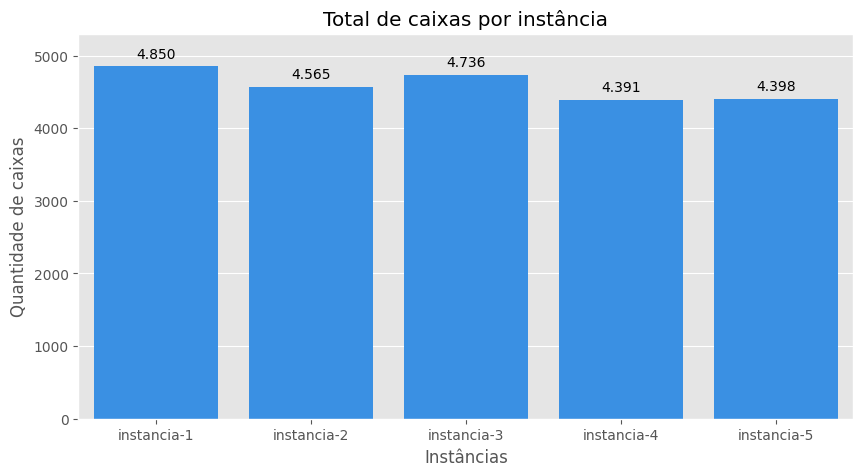

In [66]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(10, 5))
    ax =sns.barplot(data=df_output.groupby('instancia', as_index=False)['caixa_id'].nunique(), 
                  x='instancia', y= 'caixa_id',
                  color='dodgerblue')

    plt.title('Total de caixas por instância')
    plt.ylabel('Quantidade de caixas')
    plt.xlabel('Instâncias')
    plt.ylim(0,5300)

    for p in ax.patches:
            formatted_number = '{:,.0f}'.format(p.get_height()).replace(',', '.')
            ax.annotate(formatted_number, 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')

    plt.show()

In [67]:
df_output.groupby('instancia', as_index=False)['pecas'].sum()

,instancia,pecas
0,instancia-1,157483
1,instancia-2,140799
2,instancia-3,147062
3,instancia-4,136653
4,instancia-5,136720


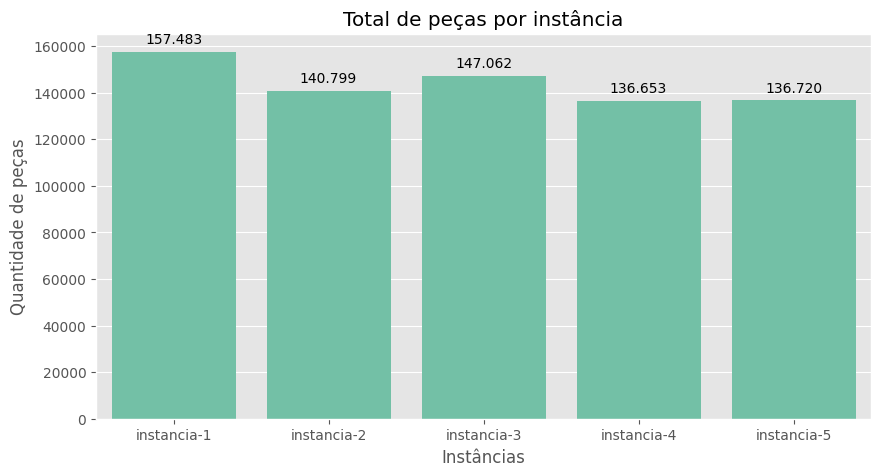

In [68]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(10, 5))
    ax =sns.barplot(data=df_output.groupby('instancia', as_index=False)['pecas'].sum(), 
                  x='instancia', y= 'pecas',
                  color='mediumaquamarine')

    plt.title('Total de peças por instância')
    plt.ylabel('Quantidade de peças')
    plt.xlabel('Instâncias')
    #plt.ylim(0,5300)

    for p in ax.patches:
            formatted_number = '{:,.0f}'.format(p.get_height()).replace(',', '.')
            ax.annotate(formatted_number, 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')

    plt.show()

## 3.2- Percentual de ocupação

In [69]:
df_output['perc_ocupacao_m3'] = df_output['sku_total_m3'] / df_output['caixa_cap_m3']

df_output[['sku_total_m3','caixa_cap_m3','perc_ocupacao_m3']]

,sku_total_m3,caixa_cap_m3,perc_ocupacao_m3
0,0.017008,0.125392,0.135637
1,0.034016,0.125392,0.271275
2,0.017008,0.125392,0.135637
3,0.005107,0.125392,0.040730
4,0.015322,0.125392,0.122190
...,...,...,...
265133,0.030129,0.091194,0.330384
265134,0.013312,0.091194,0.145975
265135,0.012501,0.091194,0.137081
265136,0.034634,0.091194,0.379781


In [70]:
df_ocupacao =  df_output.groupby(['instancia','caixa_id'], as_index=False)['sku_total_m3'].sum()
df_ocupacao

,instancia,caixa_id,sku_total_m3
0,instancia-1,caixa-1,0.121063
1,instancia-1,caixa-10,0.122362
2,instancia-1,caixa-100,0.124579
3,instancia-1,caixa-1000,0.125040
4,instancia-1,caixa-1001,0.123519
...,...,...,...
22935,instancia-5,caixa-22936,0.018340
22936,instancia-5,caixa-22937,0.122168
22937,instancia-5,caixa-22938,0.009454
22938,instancia-5,caixa-22939,0.013820


In [71]:
df_output.columns

Index(['cap_loja_m3', 'cap_rota_m3', 'caixa_cap_pecas', 'caixa_cap_kg',
       'caixa_cap_m3', 'caixa_m3_externo', 'alocacao_datahora', 'sku_unit_kg',
       'sku_unit_m3', 'inner', 'pecas', 'instancia', 'alocacao_id', 'loja',
       'rota', 'caixa_id', 'sku', 'item_pai', 'codigo_cor', 'tipo_buffer',
       'classe_onda', 'tipo_caixa', 'chave_produtos', 'sku_total_m3',
       'perc_ocupacao_m3'],
      dtype='object')

In [72]:
df_ocupacao = df_ocupacao.merge(df_output[['instancia','caixa_id', 'caixa_cap_m3']], on=['instancia','caixa_id'], how='inner')

In [73]:
df_ocupacao['perc_ocupacao_m3'] = df_ocupacao['sku_total_m3'] / df_ocupacao['caixa_cap_m3'] * 100

In [74]:
df_ocupacao

,instancia,caixa_id,sku_total_m3,caixa_cap_m3,perc_ocupacao_m3
0,instancia-1,caixa-1,0.121063,0.125392,96.547695
1,instancia-1,caixa-1,0.121063,0.125392,96.547695
2,instancia-1,caixa-1,0.121063,0.125392,96.547695
3,instancia-1,caixa-1,0.121063,0.125392,96.547695
4,instancia-1,caixa-1,0.121063,0.125392,96.547695
...,...,...,...,...,...
265133,instancia-5,caixa-22939,0.013820,0.125392,11.021477
265134,instancia-5,caixa-22940,0.013174,0.091194,14.446144
265135,instancia-5,caixa-22940,0.013174,0.091194,14.446144
265136,instancia-5,caixa-22940,0.013174,0.091194,14.446144


In [83]:
df_ocupacao.groupby('instancia', as_index=False)['perc_ocupacao_m3'].mean().style.format(precision=3)

,instancia,perc_ocupacao_m3
0,instancia-1,94.950
1,instancia-2,93.769
2,instancia-3,92.748
3,instancia-4,93.558
4,instancia-5,94.798


In [82]:
(df_ocupacao.groupby('instancia', as_index=False)['perc_ocupacao_m3'].median()).style.format(precision=3)

,instancia,perc_ocupacao_m3
0,instancia-1,98.498
1,instancia-2,98.267
2,instancia-3,98.366
3,instancia-4,98.420
4,instancia-5,98.425


In [84]:
(df_ocupacao.groupby('instancia', as_index=False)['perc_ocupacao_m3'].min()).style.format(precision=3)

,instancia,perc_ocupacao_m3
0,instancia-1,0.902
1,instancia-2,1.044
2,instancia-3,1.187
3,instancia-4,1.039
4,instancia-5,0.676


In [86]:
df_ocupacao.groupby('instancia', as_index=False)['perc_ocupacao_m3'].describe().style.format(precision=3)

,instancia,count,mean,std,min,25%,50%,75%,max
0,instancia-1,57085.000,94.950,12.738,0.902,96.901,98.498,99.339,100.000
1,instancia-2,54662.000,93.769,14.095,1.044,96.141,98.267,99.238,100.000
2,instancia-3,51086.000,92.748,16.593,1.187,96.424,98.366,99.297,99.999
3,instancia-4,54219.000,93.558,15.097,1.039,96.629,98.420,99.275,99.999
4,instancia-5,48086.000,94.798,12.903,0.676,96.833,98.425,99.291,99.999


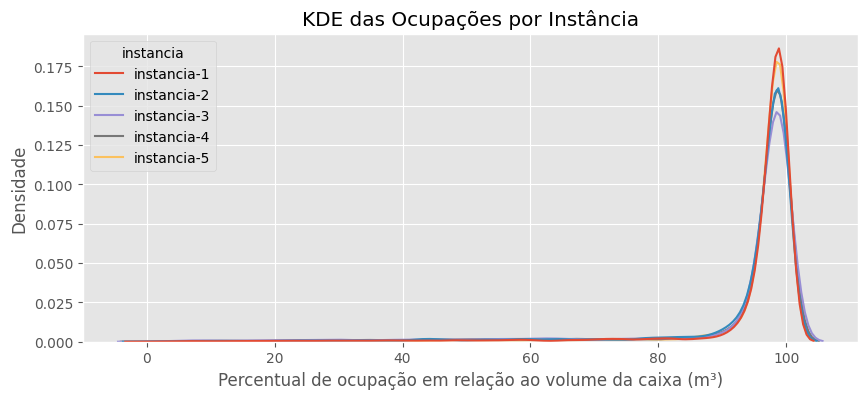

In [77]:
with plt.style.context('ggplot'):    
    plt.figure(figsize=(10, 4))
    sns.kdeplot(data=df_ocupacao, x="perc_ocupacao_m3", hue='instancia', common_norm=False)

    plt.title('KDE das Ocupações por Instância')
    plt.xlabel('Percentual de ocupação em relação ao volume da caixa (m³)')
    plt.ylabel('Densidade')
    plt.show()

## 3.3- Comparação nº de peças demanda x envio

In [93]:
df_demanda_instancia = df_producao_final.groupby('instancia', as_index=False)['pecas'].sum()
df_demanda_instancia

,instancia,pecas
0,instancia-1,171563
1,instancia-2,140799
2,instancia-3,147062
3,instancia-4,137383
4,instancia-5,137383


In [94]:
df_envio_instancia = df_output.groupby('instancia', as_index=False)['pecas'].sum()
df_envio_instancia

,instancia,pecas
0,instancia-1,157483
1,instancia-2,140799
2,instancia-3,147062
3,instancia-4,136653
4,instancia-5,136720


In [95]:
df_demanda_instancia = df_demanda_instancia.rename(columns={'pecas':'pecas_demanda'})

In [96]:
df_envio_instancia = df_envio_instancia.rename(columns={'pecas':'pecas_enviadas'})

In [98]:
df_comparacao_instancia_pecas = df_demanda_instancia.merge(df_envio_instancia, on='instancia', how='inner')
df_comparacao_instancia_pecas

,instancia,pecas_demanda,pecas_enviadas
0,instancia-1,171563,157483
1,instancia-2,140799,140799
2,instancia-3,147062,147062
3,instancia-4,137383,136653
4,instancia-5,137383,136720


In [99]:
df_comparacao_instancia_pecas['perc_envio'] = df_comparacao_instancia_pecas['pecas_enviadas']/df_comparacao_instancia_pecas['pecas_demanda']*100
df_comparacao_instancia_pecas

,instancia,pecas_demanda,pecas_enviadas,perc_envio
0,instancia-1,171563,157483,91.793102
1,instancia-2,140799,140799,100.000000
2,instancia-3,147062,147062,100.000000
3,instancia-4,137383,136653,99.468639
4,instancia-5,137383,136720,99.517408


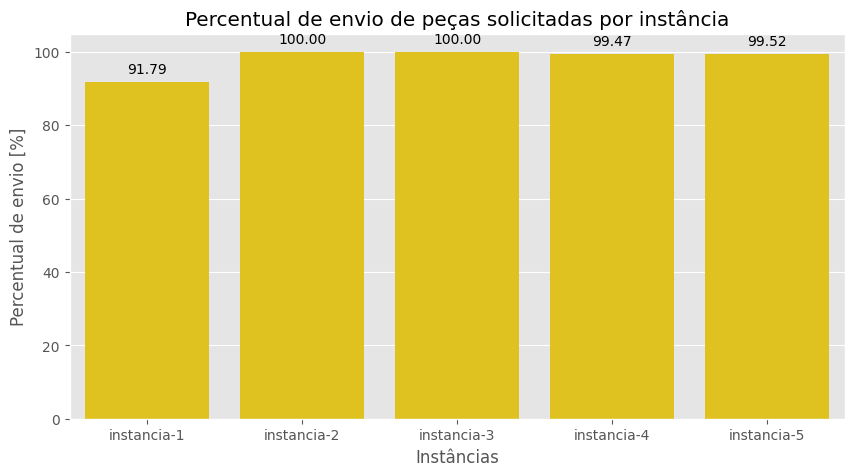

In [103]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(10, 5))
    ax =sns.barplot(data=df_comparacao_instancia_pecas,
                  x='instancia', y= 'perc_envio',
                  color='gold')

    plt.title('Percentual de envio de peças solicitadas por instância')
    plt.ylabel('Percentual de envio [%]')
    plt.xlabel('Instâncias')
    #plt.ylim(0,5300)

    for p in ax.patches:
            formatted_number = '{:,.2f}'.format(p.get_height()).replace(',', '.')
            ax.annotate(formatted_number, 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')

    plt.show()